In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from hw_utils import *

sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(12, 6)})

# Data Preprocessing

In [8]:
imdb_data = pd.read_csv('imdb.csv')

imdb_data = imdb_data.drop(columns=['Rank', 'Description', 'Director', 'Actors'])
imdb_data = imdb_data.dropna()
imdb_data = imdb_data[imdb_data['Year'] < 2014]
imdb_data = imdb_data.reset_index(drop=True)
imdb_data = imdb_data.rename(columns={'Runtime (Minutes)': 'Runtime', 'Revenue (Millions)': 'Revenue'})

imdb_data

,Title,Genre,Year,Runtime,Rating,Votes,Revenue,Metascore
0,Prometheus,"Adventure,Mystery,Sci-Fi",2012,124,7.0,485820,126.46,65.0
1,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",2011,136,6.7,395025,241.06,45.0
2,The Dark Knight,"Action,Crime,Drama",2008,152,9.0,1791916,533.32,82.0
3,The Prestige,"Drama,Mystery,Sci-Fi",2006,130,8.5,913152,53.08,66.0
4,Pirates of the Caribbean: At World's End,"Action,Adventure,Fantasy",2007,169,7.1,498821,309.40,50.0
...,...,...,...,...,...,...,...,...
433,Taare Zameen Par,"Drama,Family,Music",2007,165,8.5,102697,1.20,42.0
434,Resident Evil: Afterlife,"Action,Adventure,Horror",2010,97,5.9,140900,60.13,37.0
435,Project X,Comedy,2012,88,6.7,164088,54.72,48.0
436,Hostel: Part II,Horror,2007,94,5.5,73152,17.54,46.0


In [10]:
imdb_data_quantified = quantification_scalar(imdb_data, "Year")
imdb_data_quantified = quantification_set(imdb_data_quantified, "Genre")

imdb_data_quantified

,Title,Runtime,Rating,Votes,Revenue,Metascore,Year_2006,Year_2007,Year_2008,Year_2009,...,Genre_Mystery,Genre_Animation,Genre_Adventure,Genre_Horror,Genre_Action,Genre_Drama,Genre_War,Genre_Comedy,Genre_Thriller,Genre_Family
0,Prometheus,124,7.0,485820,126.46,65.0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,Pirates of the Caribbean: On Stranger Tides,136,6.7,395025,241.06,45.0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,The Dark Knight,152,9.0,1791916,533.32,82.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
3,The Prestige,130,8.5,913152,53.08,66.0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,Pirates of the Caribbean: At World's End,169,7.1,498821,309.40,50.0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,Taare Zameen Par,165,8.5,102697,1.20,42.0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
434,Resident Evil: Afterlife,97,5.9,140900,60.13,37.0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
435,Project X,88,6.7,164088,54.72,48.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
436,Hostel: Part II,94,5.5,73152,17.54,46.0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


# HW 2

#### 2.1 Choose 3-6 features, Explain the choice, Apply K-means:
* #### At K=5
* #### At K=9  

#### In both cases: 10 or more random initializations, chose the best over the K-means criterion

Let's use as many features as we can to give algorythm maximum information about our data. But we will not use `Genre` because then k-means will simply create clusters for major genres such as `Drama`, `Horror`, `Animation` and so on. We also will not use `Year` and `Title` because they are just metadata and provide no insides about the movie content itself.  
So the features that we will use are as follows: `Runtime`, `Rating`, `Votes`, `Revenue`, `Metascore`.

In [12]:
columns = ['Runtime', 'Rating', 'Votes', 'Revenue', 'Metascore']

imdb_data_clustered_5, inertia = cluster(imdb_data, clusters_number=5, clustering_columns_labels=columns)
imdb_data_clustered_9, inertia = cluster(imdb_data, clusters_number=9, clustering_columns_labels=columns)

#### 2.2 Interpret each of the two selected partitions by using features from the data table.
#### Make a judgement of which of the partitions is better for interpretation. Explain why.

#### 2.2.1 Clusters for $k = 5$

In [14]:
print_clusters_info(imdb_data_clustered_5, item_id_label='Title', clustering_columns_labels=columns)

Cluster № 1
------------------------------


,,Votes,Revenue,Metascore,Rating,Runtime
0,Within cluster mean,133245.780142,58.005532,43.482270,6.099291,105.702128
1,Grand mean,261530.098174,98.444269,60.408676,6.924201,116.251142
2,Difference,-128284.318032,-40.438737,-16.926406,-0.824910,-10.549014
3,"Difference, %",-0.490515,-0.410778,-0.280198,-0.119134,-0.090743


Cluster size: 141

Few items from the cluster:
- Mamma Mia!
- Diary of a Wimpy Kid
- Aliens vs Predator - Requiem
- Spring Breakers
- We're the Millers

Cluster № 2
------------------------------


,,Revenue,Runtime,Metascore,Votes,Rating
0,Within cluster mean,136.383553,131.578947,55.986842,273627.328947,6.890789
1,Grand mean,98.444269,116.251142,60.408676,261530.098174,6.924201
2,Difference,37.939283,15.327806,-4.421834,12097.230774,-0.033411
3,"Difference, %",0.385388,0.131851,-0.073199,0.046256,-0.004825


Cluster size: 76

Few items from the cluster:
- Prometheus
- Pirates of the Caribbean: On Stranger Tides
- The Help
- Thor
- 300

Cluster № 3
------------------------------


,,Revenue,Votes,Runtime,Metascore,Rating
0,Within cluster mean,329.577037,758155.296296,148.740741,71.518519,7.877778
1,Grand mean,98.444269,261530.098174,116.251142,60.408676,6.924201
2,Difference,231.132768,496625.198123,32.489599,11.109843,0.953577
3,"Difference, %",2.347854,1.898922,0.279478,0.183911,0.137717


Cluster size: 27

Few items from the cluster:
- The Dark Knight
- Pirates of the Caribbean: At World's End
- The Avengers
- Inglourious Basterds
- Pirates of the Caribbean: Dead Man's Chest

Cluster № 4
------------------------------


,,Revenue,Metascore,Runtime,Rating,Votes
0,Within cluster mean,83.331719,68.968750,103.390625,7.257031,253692.906250
1,Grand mean,98.444269,60.408676,116.251142,6.924201,261530.098174
2,Difference,-15.112551,8.560074,-12.860517,0.332830,-7837.191924
3,"Difference, %",-0.153514,0.141703,-0.110627,0.048068,-0.029967


Cluster size: 128

Few items from the cluster:
- Superbad
- Crazy, Stupid, Love.
- Scott Pilgrim vs. the World
- Frozen
- Tropic Thunder

Cluster № 5
------------------------------


,,Metascore,Votes,Revenue,Runtime,Rating
0,Within cluster mean,80.515152,333696.454545,75.903333,132.787879,7.689394
1,Grand mean,60.408676,261530.098174,98.444269,116.251142,6.924201
2,Difference,20.106476,72166.356372,-22.540936,16.536737,0.765193
3,"Difference, %",0.332841,0.275939,-0.228972,0.142250,0.110510


Cluster size: 66

Few items from the cluster:
- The Prestige
- Prisoners
- 12 Years a Slave
- The Place Beyond the Pines
- No Country for Old Men



Interpretation of clusters based on information above:   
1. Unpopular bad films  
2. Popular bad films  
3. Very popular, long and good films   
4. Unpopular good films   
5. Very good kino, popular among internet users, but made little money


#### 2.2.2 Clusters for $k = 9$

In [16]:
print_clusters_info(imdb_data_clustered_9, item_id_label='Title', clustering_columns_labels=columns)

Cluster № 1
------------------------------


,,Revenue,Metascore,Votes,Runtime,Rating
0,Within cluster mean,54.702361,70.666667,221542.305556,102.652778,7.225000
1,Grand mean,98.444269,60.408676,261530.098174,116.251142,6.924201
2,Difference,-43.741908,10.257991,-39987.792618,-13.598364,0.300799
3,"Difference, %",-0.444332,0.169810,-0.152899,-0.116974,0.043442


Cluster size: 72

Few items from the cluster:
- Scott Pilgrim vs. the World
- Tropic Thunder
- Drive
- The Perks of Being a Wallflower
- The Intouchables

Cluster № 2
------------------------------


,,Revenue,Votes,Metascore,Rating,Runtime
0,Within cluster mean,246.272667,455179.533333,74.166667,7.603333,106.000000
1,Grand mean,98.444269,261530.098174,60.408676,6.924201,116.251142
2,Difference,147.828397,193649.435160,13.757991,0.679132,-10.251142
3,"Difference, %",1.501646,0.740448,0.227749,0.098081,-0.088181


Cluster size: 30

Few items from the cluster:
- Harry Potter and the Deathly Hallows: Part 2
- Star Trek
- Frozen
- Iron Man
- Cars

Cluster № 3
------------------------------


,,Revenue,Votes,Runtime,Rating,Metascore
0,Within cluster mean,270.855429,452501.057143,140.942857,7.134286,60.685714
1,Grand mean,98.444269,261530.098174,116.251142,6.924201,60.408676
2,Difference,172.411159,190970.958969,24.691716,0.210085,0.277038
3,"Difference, %",1.751358,0.730206,0.212400,0.030341,0.004586


Cluster size: 35

Few items from the cluster:
- Pirates of the Caribbean: On Stranger Tides
- Pirates of the Caribbean: At World's End
- Pirates of the Caribbean: Dead Man's Chest
- 300
- Furious 6

Cluster № 4
------------------------------


,,Revenue,Votes,Runtime,Metascore,Rating
0,Within cluster mean,40.929677,134955.532258,97.854839,52.290323,6.469355
1,Grand mean,98.444269,261530.098174,116.251142,60.408676,6.924201
2,Difference,-57.514592,-126574.565915,-18.396303,-8.118353,-0.454846
3,"Difference, %",-0.584235,-0.483977,-0.158246,-0.134391,-0.065689


Cluster size: 62

Few items from the cluster:
- Diary of a Wimpy Kid
- Spring Breakers
- Predators
- The House Bunny
- She's Out of My League

Cluster № 5
------------------------------


,,Votes,Runtime,Revenue,Metascore,Rating
0,Within cluster mean,369785.093750,155.000000,72.790000,70.750000,7.815625
1,Grand mean,261530.098174,116.251142,98.444269,60.408676,6.924201
2,Difference,108254.995576,38.748858,-25.654269,10.341324,0.891424
3,"Difference, %",0.413929,0.333320,-0.260597,0.171189,0.128740


Cluster size: 32

Few items from the cluster:
- Inglourious Basterds
- The Wolf of Wall Street
- Prisoners
- The Help
- The Departed

Cluster № 6
------------------------------


,,Votes,Metascore,Revenue,Rating,Runtime
0,Within cluster mean,115133.962264,34.150943,62.584340,5.569811,105.528302
1,Grand mean,261530.098174,60.408676,98.444269,6.924201,116.251142
2,Difference,-146396.135909,-26.257732,-35.859930,-1.354390,-10.722840
3,"Difference, %",-0.559768,-0.434668,-0.364266,-0.195602,-0.092239


Cluster size: 53

Few items from the cluster:
- Aliens vs Predator - Requiem
- The Host
- Sucker Punch
- The Three Musketeers
- Jennifer's Body

Cluster № 7
------------------------------


,,Votes,Revenue,Metascore,Rating,Runtime
0,Within cluster mean,201049.453608,84.014948,52.556701,6.708247,119.608247
1,Grand mean,261530.098174,98.444269,60.408676,6.924201,116.251142
2,Difference,-60480.644565,-14.429321,-7.851975,-0.215953,3.357106
3,"Difference, %",-0.231257,-0.146573,-0.129981,-0.031188,0.028878


Cluster size: 97

Few items from the cluster:
- Prometheus
- Thor
- Mamma Mia!
- Pacific Rim
- Twilight

Cluster № 8
------------------------------


,,Revenue,Metascore,Votes,Rating,Runtime
0,Within cluster mean,63.860577,81.192308,321591.711538,7.605769,123.519231
1,Grand mean,98.444269,60.408676,261530.098174,6.924201,116.251142
2,Difference,-34.583692,20.783632,60061.613365,0.681568,7.268089
3,"Difference, %",-0.351302,0.344050,0.229655,0.098433,0.062521


Cluster size: 52

Few items from the cluster:
- The Prestige
- 12 Years a Slave
- No Country for Old Men
- Superbad
- Crazy, Stupid, Love.

Cluster № 9
------------------------------


,,Revenue,Votes,Runtime,Metascore,Rating
0,Within cluster mean,531.562000,1.315836e+06,153.800000,77.200000,8.440000
1,Grand mean,98.444269,2.615301e+05,116.251142,60.408676,6.924201
2,Difference,433.117731,1.054306e+06,37.548858,16.791324,1.515799
3,"Difference, %",4.399624,4.031300e+00,0.322998,0.277962,0.218913


Cluster size: 5

Few items from the cluster:
- The Dark Knight
- The Avengers
- Inception
- Avatar
- The Dark Knight Rises



Interpretation of clusters based on information above:   
1. Not very popular good films, box-office failures  
2. Popular good films with good revenue   
3. Same as cluster 2 but longer  
4. Unpopular bad movies  
5. Good long movies, popular among internet users, but made little money   
6. Very bad and very unpopular films   
7. Light version of cluster 6. Just bad and unpopular films   
8. Same as cluster 5 but movies are even better and revenue is even less   
9. Super blockbusters 

Clustering with $ k = 5 $ clusters seems more reasonable to us. With $ k = 9 $, the clusters lose their uniqueness and begin to repeat each other.

# HW 3

#### 3.1 Compare one of the features between two clusters with using bootstrap
``Metascore`` is being compared between clusters #1 and #3. 

In [18]:
metascore_cluster_one = imdb_data_clustered_9['Metascore'][imdb_data_clustered_9['Cluster'] == 0].to_numpy()
metascore_cluster_three = imdb_data_clustered_9['Metascore'][imdb_data_clustered_9['Cluster'] == 2].to_numpy()

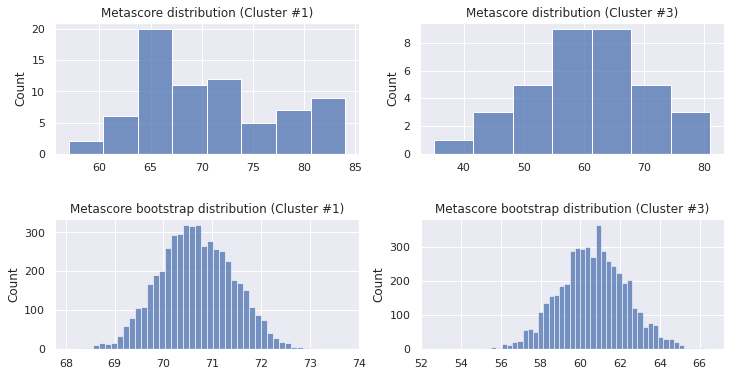

In [20]:
# Metascores' feature distribution (for 1st and 3rd clusters) w/wo bootstrap
metascore_one_stats = bootstrap(metascore_cluster_one, pivotal=False, non_pivotal=False)
metascore_three_stats = bootstrap(metascore_cluster_three, pivotal=False, non_pivotal=False)

fig, ax = plt.subplots(2,2)
sns.histplot(metascore_cluster_one, ax=ax[0, 0])
sns.histplot(metascore_cluster_three, ax=ax[0, 1])
sns.histplot(metascore_one_stats['mean_trials'], ax=ax[1, 0])
sns.histplot(metascore_three_stats['mean_trials'], ax=ax[1, 1])
ax[0, 0].set_title('Metascore distribution (Cluster #1)')
ax[0, 1].set_title('Metascore distribution (Cluster #3)')
ax[1, 0].set_title('Metascore bootstrap distribution (Cluster #1)')
ax[1, 1].set_title('Metascore bootstrap distribution (Cluster #3)')
fig.subplots_adjust(hspace = 0.5)
fig.show()

Feature ``metascore`` is being compared between clusters #1 and #3. Here, the main hypothesis $H_0: \mu_1 = \mu_2$ vs alternative $H_1: \mu_1 \ne \mu_2$. The algorithm is as it was in the lecture: bootstrap distributions of K trials in cluster #1 and #3 will be computed. Afterwards, confidense intervals for differences of means will be computed. If 0 is in interval, then $H_0$ is accepted, otherwise, rejected.

In [22]:
# Checking if means of distributions of feature Metascore from clusters #1 and #3 are equal
difference = metascore_one_stats['mean_trials'] - metascore_three_stats['mean_trials']

piv_conf_int = pivotal_conf_interval(difference)
non_piv_conf_int = non_pivotal_conf_interval(difference)

print("Pivotal confidense interval for difference of means is {:.4} - {:.4}".format(*piv_conf_int))
print("Non-pivotal confidense interval for difference of means is {:.4} - {:.4}".format(*non_piv_conf_int))

Pivotal confidense interval for difference of means is 6.369 - 13.73
Non-pivotal confidense interval for difference of means is 6.35 - 13.71


As it could be seen, intervals from both tests don't include 0 value $\implies$ means of distributions of feature ``metascore`` for cluster #1 and #3 aren't equal.

#### 3.2 Take a feature, find the 95% confidence interval for its grand mean by using bootstrap
95% confidence interval for feature ``Revenue`` will be computed

In [24]:
revenue = imdb_data_clustered_9['Revenue'].to_numpy()
stats, conf_piv, conf_non_piv = bootstrap(revenue)

In [26]:
mean = stats['mean']
std = stats['std']

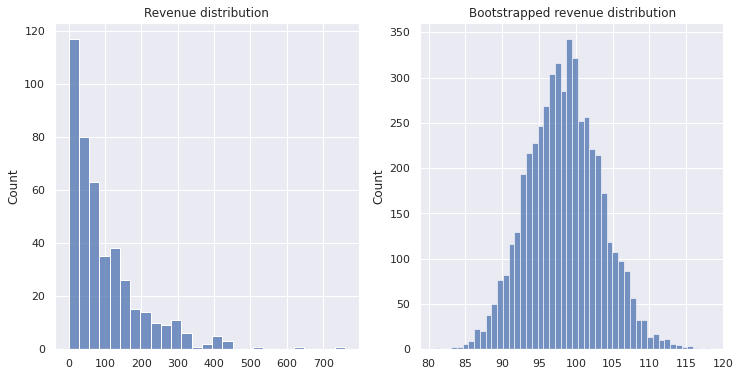

In [28]:
fig, ax = plt.subplots(1,2) 
sns.histplot(revenue, ax=ax[0])
sns.histplot(stats['mean_trials'], ax=ax[1])
ax[0].set_title('Revenue distribution')
ax[1].set_title('Bootstrapped revenue distribution')
fig.show()

In [30]:
print("Pivotal confidence interval for global mean of feature \"Revenue\" is {:.4} - {:.4}".format(*conf_piv))
print("Non-pivotal confidence interval for global mean of feature \"Revenue\" is {:.4} - {:.4}".format(*conf_non_piv))

Pivotal confidence interval for global mean of feature "Revenue" is 88.64 - 108.2
Non-pivotal confidence interval for global mean of feature "Revenue" is 88.87 - 108.3


Pivotal and non-pivotal confidence instervals for feature ``Revenue``are pretty much the same. 

#### 3.3 Take a cluster, and compare the grand mean with the within-cluster mean for the feature by using bootstrap
Here, mean and grand mean of feature ``Rating`` for cluster #5 will be compared. 

In [32]:
rating_cluster_five = imdb_data_clustered_9['Rating'][imdb_data_clustered_9['Cluster'] == 4].to_numpy()
rating = imdb_data_clustered_9['Rating'].to_numpy()

In [34]:
rating_cluster_stats = bootstrap(rating_cluster_five, pivotal=False, non_pivotal=False)
rating_global_stats = bootstrap(rating, pivotal=False, non_pivotal=False)

In [36]:
difference = rating_cluster_stats['mean_trials'] - rating_global_stats['mean_trials']

piv_conf_int = pivotal_conf_interval(difference)
non_piv_conf_int = non_pivotal_conf_interval(difference)

print("Pivotal confidense interval for difference of means is {:.4} - {:.4}".format(*piv_conf_int))
print("Non-pivotal confidense interval for difference of means is {:.4} - {:.4}".format(*non_piv_conf_int))

Pivotal confidense interval for difference of means is 0.7207 - 1.059
Non-pivotal confidense interval for difference of means is 0.7201 - 1.056


As in 3.1 intervals from both tests don't include 0 value $\implies$ means of distributions are not equal, but quite close to each other. 

# HW 4

#### 4.1. Consider three nominal features (one or two of them, not more, may be taken from nominal features in your data)

As the first nominal feature we will take `Year` - movie's release year. Our dataset contains movies from 2006 to 2013.

In [38]:
nominal_features = pd.DataFrame({'Title': imdb_data['Title']})
nominal_features.insert(loc=1, column='Year', value=imdb_data['Year'])

As the second nominal feature we will take `isDrama` - whether the film belongs to the genre of drama or not.

In [ ]:
nominal_features.insert(loc=2, column='isDrama', value=imdb_data_quantified['Genre_Drama'])

As the third nominal feature we take numerical feature `Runtime` and divide films into short, medium and long categories.  
We will call `Short` films up to 100 minutes long, `Medium` films from 100 minutes to 140 minutes, and `Long` films running more than 140 minutes.

In [39]:
runtime_feature = pd.cut(imdb_data['Runtime'], bins=[0, 100, 140, 190], labels=['Short', 'Medium', 'Long'])
nominal_features.insert(loc=3, column='Runtime', value=runtime_feature)
nominal_features

IndexError: index 3 is out of bounds for axis 0 with size 2

#### 4.2 Build two contingency tables over them: present a conditional frequency table and Quetelet relative index tables. Make comments on relations between categories of the common (to both tables) feature and two others.

Contingency tables for `Runtime` $\rightarrow$ `isDrama`

In [41]:
frequency_1, quetelet_1 = contingency_table(nominal_features, 'isDrama', 'Runtime')
display(frequency_1)
display(quetelet_1)

KeyError: 'Runtime'

Contingency tables for `Year` $\rightarrow$ `Runtime`

In [23]:
frequency_2, quetelet_2 = contingency_table(nominal_features, 'Runtime', 'Year')
display(frequency_2)
display(quetelet_2)

Year,2006,2007,2008,2009,2010,2011,2012,2013
Runtime,,,,,,,,
Short,0.073171,0.159091,0.333333,0.333333,0.280702,0.140351,0.209677,0.238095
Medium,0.731707,0.659091,0.562500,0.488889,0.666667,0.807018,0.629032,0.678571
Long,0.195122,0.181818,0.104167,0.177778,0.052632,0.052632,0.161290,0.083333


Year,2006,2007,2008,2009,2010,2011,2012,2013
Runtime,,,,,,,,
Short,-0.672972,-0.288961,0.489796,0.489796,0.254565,-0.372718,-0.062870,0.064140
Medium,0.112805,0.002367,-0.144531,-0.256481,0.013889,0.227339,-0.043347,0.031994
Long,0.643527,0.531469,-0.122596,0.497436,-0.556680,-0.556680,0.358561,-0.298077


From these tables we can see that `Long` films are more probable to be dramas than non-dramas. For `Short` films it is vice versa.  

The distribution between `Short`, `Medium` and `Long` is not very dependent on the release year and always it is more probable for the movie to be `Medium` than `Short` or `Long`. 

#### 4.3 Compute and visualize the chi-square-average_Quetelet index over both tables. Comment on the meaning of the values in the data analysis context

Quetelet's index: 1.566


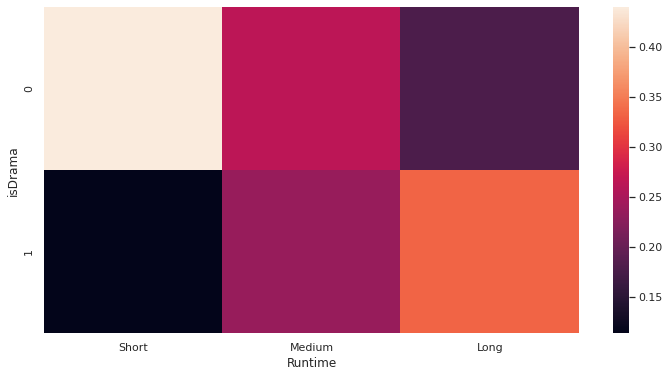

In [24]:
average_quetelet_index_1 = average_quetelet_index(frequency_1, quetelet_1)
# display(average_quetelet_index_1)
print(f"Quetelet's index: {average_quetelet_index_1.to_numpy().sum():.4}")
sns.heatmap(average_quetelet_index_1);

Quetelet's index: 4.081


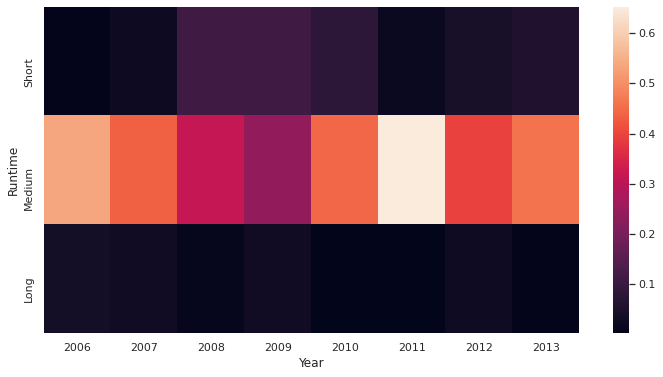

In [25]:
average_quetelet_index_2 = average_quetelet_index(frequency_2, quetelet_2)
print(f"Quetelet's index: {average_quetelet_index_2.to_numpy().sum():.4}")
sns.heatmap(average_quetelet_index_2);

Both indices are pretty big and we can infer the dependence of variables on each other. If dependence of `isDrama` from `Runtime` is intuitively correct, the dependence of `Runtime` form release `Year` is strange and seems more like a small dataset problem.

#### 4.4 Tell what numbers of observations would suffice to see the features as associated at 95% confidence level; 99% confidence level

In [26]:
n1_95 = numbers_of_observations_to_be_associated(average_quetelet_index_1, 0.95)
n1_99 = numbers_of_observations_to_be_associated(average_quetelet_index_1, 0.99)
n2_95 = numbers_of_observations_to_be_associated(average_quetelet_index_2, 0.95)
n2_99 = numbers_of_observations_to_be_associated(average_quetelet_index_2, 0.99)

print(f'Features "{average_quetelet_index_1.columns.name}" and "{average_quetelet_index_1.index.name}" are associted at confidence level 95% if number of observations is greater than {n1_95}')
print(f'Features "{average_quetelet_index_1.columns.name}" and "{average_quetelet_index_1.index.name}" are associted at confidence level 99% if number of observations is greater than {n1_99}')
print()
print(f'Features "{average_quetelet_index_2.columns.name}" and "{average_quetelet_index_2.index.name}" are associted at confidence level 95% if number of observations is greater than {n2_95}')
print(f'Features "{average_quetelet_index_2.columns.name}" and "{average_quetelet_index_2.index.name}" are associted at confidence level 99% if number of observations is greater than {n2_99}')

Features "Runtime" and "isDrama" are associted at confidence level 95% if number of observations is greater than 4
Features "Runtime" and "isDrama" are associted at confidence level 99% if number of observations is greater than 6

Features "Year" and "Runtime" are associted at confidence level 95% if number of observations is greater than 6
Features "Year" and "Runtime" are associted at confidence level 99% if number of observations is greater than 8


# HW 6

#### 6.1 Find two features in your dataset with more or less "linear-like" scatterplot

Features `Rating` and `Metascore` (user's and critique's ratings respectively) have a pretty linear scatterplot.

In [57]:
x = imdb_data['Metascore'].to_numpy()
y = imdb_data['Rating'].to_numpy()

#### 6.2 Display the scatter-plot

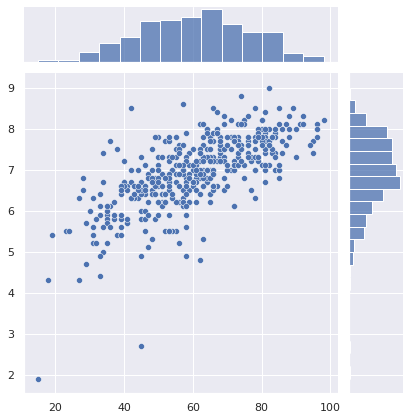

In [58]:
sns.jointplot(x=x, y=y);

#### 6.3 Build a linear regression of one of the features over the other. Make a comment on the meaning of the slope.

In [59]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x.reshape((-1, 1)), y)

print(f'Slope of linear regression model is equal to {model.coef_[0]:.4}')
print(f'Intercept of linear regression model is equal to {model.intercept_:.4}')

Slope of linear regression model is equal to 0.03768
Intercept of linear regression model is equal to 4.648


`Metascore` is measured from 0 to 100 and `Rating` is measured from 0 to 10. From the linear regression slope, we can infer that 10 points of critique's rating worth 0.38 points of user's rating.  

From the scatterplot above we have seen that despite both `Rating` and `Metascore` distributed normally, the `Rating` plot is shifted towards more positive scores, users rarely give movies ratings lower than 5. At the same time, critiques use a full specter of ratings and do not hesitate to give films very low scores. And also we can see all this from intercept and slope values.

#### 6.4 Find the correlation and determinacy coefficients, and comment on the meaning of the latter.

In [60]:
from scipy.stats import pearsonr

r, _ = pearsonr(x, y)

print(f'Correlation coefficient ρ = {r:.4}')
print(f'Determinacy coefficient ρ^2 = {r**2:.4}')

Correlation coefficient ρ = 0.6934
Determinacy coefficient ρ^2 = 0.4808


Correlation coefficient shows strong positive linear relationship between `Metascore` and `Rating`.  

From the equation
$$
L(a, b) / N = \sigma^2(y)(1 - \rho^2)
$$
we can see that the proportion of the variance $\sigma^2(y)$ taken into account by the linear regression of $y$ over $x$ is equal to
$$
1 - \rho^2 = 1 - 0.4808 = 0.5192
$$

#### 6.5 Make a prediction of the target values for given two or three predictor’ values; make a comment

In [61]:
k = 3

predictions = pd.DataFrame()

np.random.seed(42)
indices = np.random.choice(len(x), k, replace=False)

predictions['Title'] = imdb_data['Title'][indices]
predictions['True Rating'] = y[indices]
predictions['Predicted'] =  model.predict(x[indices].reshape(-1, 1))

predictions

,Title,True Rating,Predicted
364,Locke,7.1,7.700170
78,Iron Man Three,7.2,6.984169
278,RED,7.1,6.908800


For `Iron Man Three` and `RED` linear regression gave quite good predictions with error in approximately $0.2$ points. From the error for `Locke`  $\approx 0.6$ and its sign, we can conclude that film is praised by critiques and underrated by the general audience. From our experience, such cases as 'Locke` when the opinion of critics and users diverge are not uncommon. 

#### 6.6 Compare the determinacy coefficient and the mean relative absolute error of the regression on all points of your dataset and make comments

In [71]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(x.reshape(-1, 1))
mrae = 100*np.mean(np.absolute(np.divide(y - y_pred, y)))

print(f'Mean Relative Absolute Error: {mrae:.4}%')
print(f'Determinacy coefficient: {r**2:.4}')

Mean Relative Absolute Error: 7.355%
Determinacy coefficient: 0.4808


MRAE is the prediction accuracy of the model. And in our case it shows 7.355% error. Not that bad!